In [113]:
#Wczytanie potrzebnych bibliotek
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
import statsmodels.api as sm
from sklearn import linear_model
from sklearn import neighbors
import pandas as pd 
import numpy as np
import os
import json
from random import shuffle
from random import randint
from sklearn.model_selection import StratifiedKFold
from operator import itemgetter
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import time
import xgboost as xgb
path=os.getcwd()

In [2]:
#Wczytanie danych
df = pd.read_csv(path+'\\data\\data_for_model.csv')
with open(path+"/data/cat_dig_features_after_engine.txt", "r") as file:
    cat_dig_features=json.loads(file.read())
with open(path+"/data/cat_str_features_after_engine.txt", "r") as file:
    cat_str_features=json.loads(file.read())
with open(path+"/data/num_features_after_engine.txt", "r") as file:
    num_features=json.loads(file.read())
df[cat_dig_features]=df[cat_dig_features].astype('object')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103320 entries, 0 to 103319
Data columns (total 21 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Customer_Type                         103320 non-null  object 
 1   Type_of_Travel                        103320 non-null  object 
 2   Class                                 103320 non-null  object 
 3   Inflight_wifi_service                 103320 non-null  object 
 4   Departure_Or_Arrival_time_convenient  103320 non-null  object 
 5   Ease_of_Online_booking                103320 non-null  object 
 6   Gate_location                         103320 non-null  object 
 7   Food_and_drink                        103320 non-null  object 
 8   Online_boarding                       103320 non-null  object 
 9   Seat_comfort                          103320 non-null  object 
 10  Inflight_entertainment                103320 non-null  object 
 11  

In [3]:
features=cat_dig_features+cat_str_features+num_features
target='satisfaction'

Modelowanie będzie przeprowadzone za pomocą czterech modeli: Regresji logistycznej, KNN, Random Forest oraz gradient boosting. Do porównywania wyników zostanie użyta metryka dla prawdopodobieństw roc auc score.

## 1. Regresja logistyczna

Zacznijmy modelowanie od ekonometrii i od modelu regresji logistycznej przeznaczonego do problemów klasyfikacyjnych. Zacznijmy od przygotowania zmiennych do tego typu estymacji. Należy zmienne kategoryczne zamienić na 0-1, gdyż zmienne te są nieuporządkowane, dlatego potraktowanie każdego poziomu oddzielnie da najlepsze rezultaty.

In [4]:
data_for_lr=df.copy()
# One hot encoding
dummLev = pd.get_dummies(data_for_lr[cat_dig_features+cat_str_features], drop_first=True)

# Połączenie zmiennych numerycznych, kategorycznych w postaci on hot encoding oraz targetu
data_for_lr = pd.concat([data_for_lr[num_features], dummLev, data_for_lr[[target]]], axis=1)
data_for_lr['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1},inplace = True)
display(data_for_lr.head())

,Age,Flight_Distance,Delay_in_Minutes,Inflight_wifi_service_1,Inflight_wifi_service_2,Inflight_wifi_service_3,Inflight_wifi_service_4,Inflight_wifi_service_5,Departure_Or_Arrival_time_convenient_1,Departure_Or_Arrival_time_convenient_2,...,Inflight_service_5,Cleanliness_2,Cleanliness_3,Cleanliness_4,Cleanliness_5,Customer_Type_disloyal Customer,Type_of_Travel_Personal Travel,Class_Eco,Class_Eco Plus,satisfaction
0,13,460,43.0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,1,0,1,0
1,25,235,7.0,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,26,1142,0.0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
3,25,562,20.0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,61,214,0.0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


Trzeba zamienić spacje w nazwach zmiennych na znak podłogi, ponieważ regresja logistyczna z formuły ma problem z białymi znakami

In [5]:
data_for_lr.columns = [c.replace(' ', '_') for c in data_for_lr.columns]
print(data_for_lr.info())
features_for_lr=data_for_lr.columns.tolist()
features_for_lr.remove('satisfaction')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103320 entries, 0 to 103319
Data columns (total 68 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   Age                                     103320 non-null  int64  
 1   Flight_Distance                         103320 non-null  int64  
 2   Delay_in_Minutes                        103320 non-null  float64
 3   Inflight_wifi_service_1                 103320 non-null  uint8  
 4   Inflight_wifi_service_2                 103320 non-null  uint8  
 5   Inflight_wifi_service_3                 103320 non-null  uint8  
 6   Inflight_wifi_service_4                 103320 non-null  uint8  
 7   Inflight_wifi_service_5                 103320 non-null  uint8  
 8   Departure_Or_Arrival_time_convenient_1  103320 non-null  uint8  
 9   Departure_Or_Arrival_time_convenient_2  103320 non-null  uint8  
 10  Departure_Or_Arrival_time_convenient_3  1033

Początkowy wrapper do regresji logistycznej

In [6]:
def CVTest(df,nFolds = 5, features = [], randomState=42, debug=False):
    # Podzielenie zbioru na foldy
    kf = KFold(n_splits = nFolds, shuffle=True, random_state=randomState)
    # Stworzenie listy z wynikami
    testResults = []
    trainResults=[]
    f_list = "+".join(features)
    
    # Pętla do estymacji i walidacji modeli na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Stworzenie modelu
        mod = sm.GLM.from_formula(formula=target+"~"+f_list,
                                  data=df.iloc[train], family=sm.families.Binomial())
        # Estymacja
        res = mod.fit()
        # Zapisanie predykcji
        predsTrain = res.predict()
        preds = res.predict(df.iloc[test])
        
        # Zapisanie wyników ze zbioru walidacyjnego do listy
        trainResults.append(roc_auc_score(df[target].iloc[train], predsTrain))
        testResults.append(roc_auc_score(df[target].iloc[test], preds))
        
    # Dla debug wyświetlimy podsumowanie ostatniego foldu
    if debug:
        display(res.summary())
    
    # Zwracamy średnią z wyników    
    return np.mean(trainResults), np.mean(testResults)


In [7]:
CVTest(df=data_for_lr,features=features_for_lr,debug=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           satisfaction   No. Observations:                82656
Model:                            GLM   Df Residuals:                    82588
Model Family:                Binomial   Df Model:                           67
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14727.
Date:                Tue, 08 Jun 2021   Deviance:                       29455.
Time:                        09:44:53   Pearson chi2:                 4.22e+05
No. Iterations:                    27                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 31.2473   1.58e+04      0.002      0.998    -3.1e+04    3.11e+04
Age                                       -0.0025      0.001     -2.171      0.030      -0.005      -0.000
Flight_Distance                          8.61e-07   1.72e-05      0.050      0.960   -3.29e-05    3.46e-05
Delay_in_Minutes                          -0.0019      0.000    -10.229      0.000      -0.002      -0.002
Inflight_wifi_service_1                  -33.3426   1.58e+04     -0.002      0.998   -3.11e+04     3.1e+04
Inflight_wifi_service_2                  -33.5933   1.58e+04     -0.002      0.998   -3.11e+04     3.1e+04
Inflight_wifi_service_3                  -33.6351   1.58e+04     -0.002      0.998   -3.11e+04     3.1e+04
Inflight_wifi_service_4                  -32.0977   1.58e+04     -0.002      0.998   -3.11e+04     3.1e+04
Inflight_wifi_service_5                  -26.4112   1.58e+04     -0.002      0.999   -3.11e+04     3.1e+04
Departure_Or_Arrival_time_convenient_1     0.2820      0.104      2.699      0.007       0.077       0.487
Departure_Or_Arrival_time_convenient_2     0.4165      0.101      4.135      0.000       0.219       0.614
Departure_Or_Arrival_time_convenient_3     0.2060      0.097      2.125      0.034       0.016       0.396
Departure_Or_Arrival_time_convenient_4    -0.7184      0.087     -8.266      0.000      -0.889      -0.548
Departure_Or_Arrival_time_convenient_5    -1.0007      0.096    -10.478      0.000      -1.188      -0.813
Ease_of_Online_booking_1                   3.0336      0.957      3.170      0.002       1.158       4.909
Ease_of_Online_booking_2                   2.8792      0.957      3.009      0.003       1.004       4.755
Ease_of_Online_booking_3                   3.4127      0.957      3.567      0.000       1.538       5.288
Ease_of_Online_booking_4                   4.2467      0.956      4.440      0.000       2.372       6.121
Ease_of_Online_booking_5                   3.6617      0.957      3.827      0.000       1.786       5.537
Gate_location_2                            0.1169      0.069      1.704      0.088      -0.018       0.251
Gate_location_3                           -0.0873      0.063     -1.377      0.168      -0.211       0.037
Gate_location_4                           -0.2819      0.065     -4.321      0.000      -0.410      -0.154
Gate_location_5                           -0.4561      0.084     -5.423      0.000      -0.621      -0.291
Food_and_drink_2                           0.2587      0.076      3.411      0.001       0.110       0.407
Food_and_drink_3                           0.1307      0.075      1.739      0.082      -0.017       0.278
Food_and_drink_4                           0.1367      0.075      1.828      0.068     

(0.9792731844180664, 0.9790675322015984)

Otrzymaliśmy wynik 0.97906 na zbiorze testowym co jest bardzo dobrym wynikiem, jednakże można zauważyć, że kilka zmiennych wyszło nieistotnych statystycznie. Na przykład wszystkie poziomy inflight_wifi_service są nieistotne. Przetestujmy ich łączną nieistotność za pomocą statystyki LR

In [8]:
features_for_lr_out_wifi_service=features_for_lr.copy()
features_for_lr_out_wifi_service.remove('Inflight_wifi_service_1')
features_for_lr_out_wifi_service.remove('Inflight_wifi_service_2')
features_for_lr_out_wifi_service.remove('Inflight_wifi_service_3')
features_for_lr_out_wifi_service.remove('Inflight_wifi_service_4')
features_for_lr_out_wifi_service.remove('Inflight_wifi_service_5')
CVTest(df=data_for_lr,features=features_for_lr_out_wifi_service,debug=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           satisfaction   No. Observations:                82656
Model:                            GLM   Df Residuals:                    82593
Model Family:                Binomial   Df Model:                           62
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19535.
Date:                Tue, 08 Jun 2021   Deviance:                       39071.
Time:                        09:45:00   Pearson chi2:                 1.28e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  2.1981      0.130     16.938      0.000       1.944       2.452
Age                                       -0.0061      0.001     -6.383      0.000      -0.008      -0.004
Flight_Distance                         2.147e-05   1.53e-05      1.401      0.161   -8.58e-06    5.15e-05
Delay_in_Minutes                          -0.0021      0.000    -12.806      0.000      -0.002      -0.002
Departure_Or_Arrival_time_convenient_1     0.3019      0.082      3.669      0.000       0.141       0.463
Departure_Or_Arrival_time_convenient_2     0.4946      0.080      6.185      0.000       0.338       0.651
Departure_Or_Arrival_time_convenient_3     0.2834      0.076      3.710      0.000       0.134       0.433
Departure_Or_Arrival_time_convenient_4    -0.5083      0.068     -7.490      0.000      -0.641      -0.375
Departure_Or_Arrival_time_convenient_5    -0.6999      0.072     -9.722      0.000      -0.841      -0.559
Ease_of_Online_booking_1                  -3.3606      0.148    -22.743      0.000      -3.650      -3.071
Ease_of_Online_booking_2                  -3.8263      0.147    -26.085      0.000      -4.114      -3.539
Ease_of_Online_booking_3                  -3.4040      0.144    -23.620      0.000      -3.687      -3.122
Ease_of_Online_booking_4                  -2.0588      0.142    -14.508      0.000      -2.337      -1.781
Ease_of_Online_booking_5                  -1.2573      0.143     -8.773      0.000      -1.538      -0.976
Gate_location_2                            0.1604      0.056      2.855      0.004       0.050       0.271
Gate_location_3                            0.0152      0.052      0.294      0.769      -0.086       0.117
Gate_location_4                           -0.1409      0.053     -2.668      0.008      -0.244      -0.037
Gate_location_5                           -0.5604      0.065     -8.635      0.000      -0.688      -0.433
Food_and_drink_2                           0.2088      0.066      3.145      0.002       0.079       0.339
Food_and_drink_3                           0.0864      0.066      1.315      0.189      -0.042       0.215
Food_and_drink_4                           0.1083      0.066      1.653      0.098      -0.020       0.237
Food_and_drink_5                           0.0561      0.067      0.831      0.406      -0.076       0.188
Online_boarding_1                         -1.0311      0.151     -6.809      0.000      -1.328      -0.734
Online_boarding_2                         -1.1072      0.152     -7.292      0.000      -1.405      -0.810
Online_boarding_3                         -1.1453      0.150     -7.637      0.000      -1.439      -0.851
Online_boarding_4                          0.8131      0.149      5.442      0.000     

(0.964064013763136, 0.96377025923245)

In [9]:
lr_test=2*(-14727+19535)
lr_test

9616

Statystyka LR wyniosła 9616 a wartość rozkładu chi-kwadrat z 5 stopniami swobody dla poziomu istotności 5% wynosi 11.07 dlatego odrzucamy hipotezę zerową o łącznej nieistotności tych zmiennych, czyli poziom zadowolenia z usług wifi jest istotny dla prognozowania. Sprawdźmy w takim razie drugą nieistotną zmienną, czyli Flight_Distance czy wynik bez niej się poprawi.

In [10]:
features_for_lr_out_Flight_Distance=features_for_lr.copy()
features_for_lr_out_Flight_Distance.remove('Flight_Distance')
CVTest(df=data_for_lr,features=features_for_lr_out_Flight_Distance,debug=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           satisfaction   No. Observations:                82656
Model:                            GLM   Df Residuals:                    82589
Model Family:                Binomial   Df Model:                           66
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14727.
Date:                Tue, 08 Jun 2021   Deviance:                       29455.
Time:                        09:45:17   Pearson chi2:                 4.22e+05
No. Iterations:                    27                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 31.2492   1.58e+04      0.002      0.998    -3.1e+04    3.11e+04
Age                                       -0.0025      0.001     -2.180      0.029      -0.005      -0.000
Delay_in_Minutes                          -0.0019      0.000    -10.229      0.000      -0.002      -0.002
Inflight_wifi_service_1                  -33.3431   1.58e+04     -0.002      0.998   -3.11e+04     3.1e+04
Inflight_wifi_service_2                  -33.5939   1.58e+04     -0.002      0.998   -3.11e+04     3.1e+04
Inflight_wifi_service_3                  -33.6357   1.58e+04     -0.002      0.998   -3.11e+04     3.1e+04
Inflight_wifi_service_4                  -32.0984   1.58e+04     -0.002      0.998   -3.11e+04     3.1e+04
Inflight_wifi_service_5                  -26.4117   1.58e+04     -0.002      0.999   -3.11e+04     3.1e+04
Departure_Or_Arrival_time_convenient_1     0.2822      0.104      2.701      0.007       0.077       0.487
Departure_Or_Arrival_time_convenient_2     0.4167      0.101      4.137      0.000       0.219       0.614
Departure_Or_Arrival_time_convenient_3     0.2062      0.097      2.127      0.033       0.016       0.396
Departure_Or_Arrival_time_convenient_4    -0.7183      0.087     -8.267      0.000      -0.889      -0.548
Departure_Or_Arrival_time_convenient_5    -1.0006      0.095    -10.479      0.000      -1.188      -0.813
Ease_of_Online_booking_1                   3.0335      0.957      3.170      0.002       1.158       4.909
Ease_of_Online_booking_2                   2.8791      0.957      3.009      0.003       1.004       4.755
Ease_of_Online_booking_3                   3.4126      0.957      3.567      0.000       1.537       5.288
Ease_of_Online_booking_4                   4.2466      0.956      4.440      0.000       2.372       6.121
Ease_of_Online_booking_5                   3.6617      0.957      3.827      0.000       1.786       5.537
Gate_location_2                            0.1169      0.069      1.705      0.088      -0.018       0.251
Gate_location_3                           -0.0872      0.063     -1.377      0.169      -0.211       0.037
Gate_location_4                           -0.2819      0.065     -4.321      0.000      -0.410      -0.154
Gate_location_5                           -0.4562      0.084     -5.425      0.000      -0.621      -0.291
Food_and_drink_2                           0.2587      0.076      3.410      0.001       0.110       0.407
Food_and_drink_3                           0.1307      0.075      1.739      0.082      -0.017       0.278
Food_and_drink_4                           0.1367      0.075      1.828      0.068      -0.010       0.283
Food_and_drink_5                           0.0260      0.077      0.338      0.735     

(0.9792723026357735, 0.9790685661972031)

Wynik poprawił się nieznacznie z 0.979067 na 0.979068, dlatego usuwamy tą zmienną i w celu dalszej poprawy poddamy model regularyzacji.

In [11]:
features_for_lr=features_for_lr_out_Flight_Distance.copy()

### 1.1 Regularyzacja regresji logistycznej 

In [12]:
#Wrapper dla regularyzacji regresji logistycznej
def CVTestLinearClass(df,nFolds = 5, randomState=42, debug=False, features=features, saveModels = False, *args, **kwargs):
    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Zapiszmy wyniki na zbiorze treningowym i testowym:
    testResults = []
    trainResults = []
    
    # Przechowajmy również predykcje dla poszczególnych foldów
    predictions = []
    
    # Razem z informacją o tym, jaki był ich indeks w oryginalnym zbiorze danych
    indices = []
    
    # Przygotujmy liste modeli do zachowania
    models = []
    for train, test in kf.split(df.index.values):

        # Przygotowanie estymatora
        clf = linear_model.LogisticRegression(*args, **kwargs)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Przygotowanie prognoz dla zbioru traeningowego i testowego
        # UWAGA Sklearn zwracałbędzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        trainScore = roc_auc_score(df[target].iloc[train], predsTrain)
        testScore = roc_auc_score(df[target].iloc[test], preds)
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        if saveModels:
            models.append(clf)
        
    return trainResults, testResults, predictions, indices, models

Najpierw model bez regularyzacji

In [13]:
import warnings
warnings.filterwarnings("ignore")
trainResults, testResults, predictions, indices, models = CVTestLinearClass(df=data_for_lr,features=features_for_lr,penalty="none",max_iter=2000)
print('Train', np.mean(trainResults), "Test", np.mean(testResults))

Train 0.9792399038447923 Test 0.9790442013853987


Otrzymujemy podobne wyniki jak w przypadku zastosowania metody z modułu stats. Zastosujmy teraz regularyzację L1, co wymaga użycia innego solvera liblinear. Dokonajmy odrazu optymalizacji hiperparametrów i sprawdźmy czy regularyzacja L1 poprawi wyniki predykcji

In [14]:
for alpha in [0.01, 0.1, 0.25, 0.5, 1, 2]:
    trainResults, testResults, predictions, indices, models = CVTestLinearClass(df=data_for_lr,features=features_for_lr,penalty="l1", solver="liblinear", C=alpha,max_iter=2000)
    print("Alpha:", alpha, "Train", np.mean(trainResults), "Test", np.mean(testResults))

Alpha: 0.01 Train 0.976425306249935 Test 0.9762763937080461
Alpha: 0.1 Train 0.9790136647245807 Test 0.9788268365700891
Alpha: 0.25 Train 0.9791398885114994 Test 0.9789410162533343
Alpha: 0.5 Train 0.9791864134825958 Test 0.9789858590349532
Alpha: 1 Train 0.9791999635715889 Test 0.9789952409560584
Alpha: 2 Train 0.9792158293841462 Test 0.9790114371288036


Nie widać żadnej poprawy przy zastosowaniu regularyzacji Lasso. Może regularyzajca metodą L2 przyniesie lepszy rezultat

In [15]:
import warnings
warnings.filterwarnings("ignore")
for alpha in [0.01, 0.1, 0.25, 0.5, 1, 2,5,20]:
    trainResults, testResults, predictions, indices, models = CVTestLinearClass(df=data_for_lr,features=features_for_lr,penalty="l2", C=alpha,max_iter=2000)
    print("Alpha:", alpha, "Train", np.mean(trainResults), "Test", np.mean(testResults))

Alpha: 0.01 Train 0.9758846568398477 Test 0.9757057297864437
Alpha: 0.1 Train 0.9785020264475864 Test 0.9783090842370405
Alpha: 0.25 Train 0.9788842968821194 Test 0.9786872680764223
Alpha: 0.5 Train 0.979039905836467 Test 0.9788429003570889
Alpha: 1 Train 0.9791253728544422 Test 0.978928118097268
Alpha: 2 Train 0.9791832078300354 Test 0.978981129207283
Alpha: 5 Train 0.9792053597831616 Test 0.9790044708495771
Alpha: 20 Train 0.9792273492967662 Test 0.9790175394167502


Również metoda Ridge nie przyniosła lepszych rezultatów. Nie sprawdzamy w takim razie metody Elastic Net, która jest tylko połączeniem tych dwóch metod i ostateczny wniosek jest taki, że regularyzacja regresji logistycznej w tym problemie nie przyniosła dobrych efektów. Zapiszmy najlepszy wynik i przejdźmy do algorytmu KNN

In [16]:
trainResults, testResults, predictions, indices,models = CVTestLinearClass(df=data_for_lr,features=features_for_lr,penalty="none",max_iter=2000)
print(np.mean(testResults))
modelLR = {
    "name":"Regresja Logistyczna",
    "description":" Model Regresji logistycznej, usunięta zmienna nieistotna Flight Distance",
    "specification":'n_neighbors=17, n_jobs=-1, p=2, features=featuresSet_for_knn',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.9790442013853987


## 2. K-Nearest Neighbors


Ponowne przygotowanie danych do kolejnego modelu. Zastosowanie One-Hot Encoding oraz wystandaryzowanie zmiennych nominalnych, co jest kluczowe w algorytmie KNN.

In [17]:
data_for_knn=df.copy()
# One hot encoding
dummLev = pd.get_dummies(data_for_knn[cat_dig_features+cat_str_features], drop_first=True)

# Połączenie zmiennych numerycznych, kategorycznych w postaci on hot encoding oraz targetu
data_for_knn = pd.concat([data_for_knn[num_features], dummLev, data_for_knn[[target]]], axis=1)
display(data_for_knn.head())

,Age,Flight_Distance,Delay_in_Minutes,Inflight_wifi_service_1,Inflight_wifi_service_2,Inflight_wifi_service_3,Inflight_wifi_service_4,Inflight_wifi_service_5,Departure_Or_Arrival_time_convenient_1,Departure_Or_Arrival_time_convenient_2,...,Inflight_service_5,Cleanliness_2,Cleanliness_3,Cleanliness_4,Cleanliness_5,Customer_Type_disloyal Customer,Type_of_Travel_Personal Travel,Class_Eco,Class_Eco Plus,satisfaction
0,13,460,43.0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,1,0,1,neutral or dissatisfied
1,25,235,7.0,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,neutral or dissatisfied
2,26,1142,0.0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,satisfied
3,25,562,20.0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,neutral or dissatisfied
4,61,214,0.0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,satisfied


In [18]:
data_for_knn.columns = [c.replace(' ', '_') for c in data_for_knn.columns]
print(data_for_knn.info())
features_for_knn=data_for_knn.columns.tolist()
features_for_knn.remove('satisfaction')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103320 entries, 0 to 103319
Data columns (total 68 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   Age                                     103320 non-null  int64  
 1   Flight_Distance                         103320 non-null  int64  
 2   Delay_in_Minutes                        103320 non-null  float64
 3   Inflight_wifi_service_1                 103320 non-null  uint8  
 4   Inflight_wifi_service_2                 103320 non-null  uint8  
 5   Inflight_wifi_service_3                 103320 non-null  uint8  
 6   Inflight_wifi_service_4                 103320 non-null  uint8  
 7   Inflight_wifi_service_5                 103320 non-null  uint8  
 8   Departure_Or_Arrival_time_convenient_1  103320 non-null  uint8  
 9   Departure_Or_Arrival_time_convenient_2  103320 non-null  uint8  
 10  Departure_Or_Arrival_time_convenient_3  1033

In [19]:
#Wystandaryzowanie zmiennych nominalnych
data_for_knn_stand_1=data_for_knn.copy()
data_for_knn_stand_1[num_features] = data_for_knn_stand_1[num_features].apply(lambda x: (x-x.mean())/x.std())

Ze względu na długi czas trenowania modelu na pełnej próbie, korzystamy jedynie z 5000 obserwacji w procesie estymacji aby szybciej zoptymalizować algorytm.

In [20]:

# Przygotujmy wrapper
def CVTestKNN(df,nFolds = 5, randomState=42, debug=False, features=features,sampleSize=5000, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Listy z wynikami
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = neighbors.KNeighborsClassifier(*args, **kwargs)
        if debug:
            print(clf)
        #Zmniejszenie zbioru treningowego przez sampling
        sampleSize = sampleSize
        if(sampleSize!=None):
            X = df.iloc[train].sample(sampleSize,random_state=randomState)
            # Trenowanie modelu
            clf.fit(X[features], X[target])
        else:
            clf.fit(df.iloc[train][features],df.iloc[train][target])
        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracałbędzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie ROC-AUC dla foldów
        trainScore = roc_auc_score((df[target].iloc[train]=="satisfied").astype(int), predsTrain)
        testScore = roc_auc_score((df[target].iloc[test]=="satisfied").astype(int), preds)
        
        # Zapisanie wyników dla foldów
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices


In [21]:
trainResults, testResults, predictions, indices = CVTestKNN(df=data_for_knn_stand_1,features=features_for_knn,n_neighbors=5, n_jobs=-1, p=2, debug=True)
print(np.mean(testResults))

KNeighborsClassifier(n_jobs=-1)
Train AUC: 0.9605222375544984 Valid AUC: 0.955470852761105
KNeighborsClassifier(n_jobs=-1)
Train AUC: 0.9596943568166414 Valid AUC: 0.9569259986402132
KNeighborsClassifier(n_jobs=-1)
Train AUC: 0.9595613182387976 Valid AUC: 0.9578357720878181
KNeighborsClassifier(n_jobs=-1)
Train AUC: 0.9585655920425205 Valid AUC: 0.9557562982391069
KNeighborsClassifier(n_jobs=-1)
Train AUC: 0.9595403104329124 Valid AUC: 0.9582346843487064
0.9568447212153899


Bez tuningu hyperparametrów oraz na małej liczbie obserwacji uzyskano wynik 0.9568. Pierwszą rzeczą, którą warto sprawdzić jest zmiana sposobu standaryzacji zmiennych. Może poprawi to wynik.

In [22]:
#Wystandaryzowanie zmiennych nominalnych metodą min-max scanling
data_for_knn_stand_2=data_for_knn.copy()
data_for_knn_stand_2[num_features] = data_for_knn_stand_2[num_features].apply(lambda x: (x-x.min())/(x.max()-x.min()))

In [23]:
trainResults, testResults, predictions, indices = CVTestKNN(df=data_for_knn_stand_2,features=features_for_knn,n_neighbors=5, n_jobs=-1, p=2, debug=True)
print(np.mean(testResults))

KNeighborsClassifier(n_jobs=-1)
Train AUC: 0.9632228782924092 Valid AUC: 0.9599255427835581
KNeighborsClassifier(n_jobs=-1)
Train AUC: 0.9624772154760945 Valid AUC: 0.9588345069646128
KNeighborsClassifier(n_jobs=-1)
Train AUC: 0.9627422620976535 Valid AUC: 0.9614631436869929
KNeighborsClassifier(n_jobs=-1)
Train AUC: 0.962234785647482 Valid AUC: 0.9595382210800014
KNeighborsClassifier(n_jobs=-1)
Train AUC: 0.962668726478084 Valid AUC: 0.9602486572522653
0.9600020143534861


Przy wykorzystaniu metody min-max scaling otrzymaliśmy nieznacznie lepszy wynik, dlatego będziemy ją wykorzystywać w dalszym procesie.

### 2.1. Inżynieria zmiennych dla KNN

Ze względu na czas wykonywania oraz zoptymalizowanie wyników dokonamy dodatkowej inżynierii zmiennych. Przede wszystkim chcemy zredukować wymiar więc należy wybrać najważniejsze dla modelu zmienne, a dokonamy to poprzez tworzenie modelu dla każdej zmiennej pojedynczo.

In [24]:
# Następnie będziemy dodawać każdą zmienną jako osobnego kandydata.
results = []
for feature in features_for_knn:
    # Estymacja modelu
    trainResults, testResults, predictions, indices = CVTestKNN(df=data_for_knn_stand_2,n_neighbors=5, n_jobs=-1, p=2, features=[feature])
    # Zapisanie wyniku jako do obiektu results
    results.append((feature, np.mean(testResults)))

In [25]:
results = sorted(results, key=lambda x: x[1], reverse=True)
results

[('Type_of_Travel_Personal_Travel', 0.7107183525528464),
 ('Class_Eco', 0.6816912372342983),
 ('Online_boarding_5', 0.6787751926521283),
 ('Inflight_wifi_service_5', 0.6258007875581215),
 ('Online_boarding_4', 0.6148324278907751),
 ('Flight_Distance', 0.6098137781236134),
 ('Inflight_wifi_service_2', 0.5934550980419929),
 ('Age', 0.5926529697506413),
 ('Seat_comfort_5', 0.5899382896240958),
 ('Online_boarding_2', 0.5878095089684882),
 ('Inflight_entertainment_5', 0.5863078835940883),
 ('Seat_comfort_3', 0.5813223426915536),
 ('Onboard_service_5', 0.5781649352371157),
 ('Inflight_wifi_service_3', 0.5744820758427217),
 ('Leg_room_service_5', 0.5702323444382758),
 ('Leg_room_service_4', 0.5680131246554947),
 ('Baggage_handling_3', 0.5646426033132297),
 ('Inflight_entertainment_3', 0.5616510812656479),
 ('Online_boarding_1', 0.549922809105347),
 ('Customer_Type_disloyal_Customer', 0.5449497887550994),
 ('Inflight_entertainment_4', 0.5414414887519174),
 ('Inflight_service_5', 0.539205569546

Najbardziej istotną zmienną okazała się zmienna binarna mówiąca czy dla danego pasażera lot był lotem prywatnym Spróbujmy oszacować model ze zmiennymi, który wynik dał więcej niż 0.52

In [26]:
featuresSet_for_knn = [x for x,y in results if y > 0.52]
print(featuresSet_for_knn)

['Type_of_Travel_Personal_Travel', 'Class_Eco', 'Online_boarding_5', 'Inflight_wifi_service_5', 'Online_boarding_4', 'Flight_Distance', 'Inflight_wifi_service_2', 'Age', 'Seat_comfort_5', 'Online_boarding_2', 'Inflight_entertainment_5', 'Seat_comfort_3', 'Onboard_service_5', 'Inflight_wifi_service_3', 'Leg_room_service_5', 'Leg_room_service_4', 'Baggage_handling_3', 'Inflight_entertainment_3', 'Online_boarding_1', 'Customer_Type_disloyal_Customer', 'Inflight_entertainment_4', 'Inflight_service_5', 'Leg_room_service_2', 'Ease_of_Online_booking_3', 'Seat_comfort_2', 'Inflight_service_3', 'Cleanliness_5', 'Onboard_service_2', 'Inflight_entertainment_2', 'Food_and_drink_5', 'Baggage_handling_4', 'Cleanliness_2', 'Checkin_service_2', 'Food_and_drink_4', 'Gate_location_5', 'Inflight_wifi_service_1', 'Onboard_service_3', 'Delay_in_Minutes']


In [27]:
trainResults, testResults, predictions, indices = CVTestKNN(df=data_for_knn_stand_2,features=featuresSet_for_knn,n_neighbors=5, n_jobs=-1, p=2)
print(np.mean(testResults))

0.9629404634679908


Poprawiło to wynik, więc może jeszcze większe ograniczenie zbioru poprawi bardziej

In [28]:
featuresSet_for_knn2 = [x for x,y in results if y > 0.53]
trainResults, testResults, predictions, indices = CVTestKNN(df=data_for_knn_stand_2,features=featuresSet_for_knn2,n_neighbors=5, n_jobs=-1, p=2)
print(np.mean(testResults))

0.9589703398076346


Niestety wynik pogorszył się, dlatego może spróbujmy zmienić punkt odcięcia w drugą stronę

In [29]:
featuresSet_for_knn3 = [x for x,y in results if y > 0.51]
trainResults, testResults, predictions, indices = CVTestKNN(df=data_for_knn_stand_2,features=featuresSet_for_knn3,n_neighbors=5, n_jobs=-1, p=2)
print(np.mean(testResults))

0.9629341453006607


Wynik względem pierwszej selekcji nie poprawił się więc pozostajemy przy tamtym zestawie zmiennych

Innym sposobem na poprawę wyniku jest skalowanie zmiennych, więc sprawdźmy czy zwiększenie znaczenia najważniejszych zmiennych oraz zmniejszenie znaczenia najmniej istotnych zmiennych poprawi wynik

In [30]:
for k in [1.5, 2, 3, 4, 5]:
    data_for_knn_engine = data_for_knn_stand_2.copy()
    # k krotnie zwiększamy zmienną
    data_for_knn_engine["Type_of_Travel_Personal_Travel"]=data_for_knn_engine["Type_of_Travel_Personal_Travel"]*k
    trainResults, testResults, predictions, indices = CVTestKNN(df=data_for_knn_engine,n_neighbors=5, n_jobs=-1, p=2, features=featuresSet_for_knn)
    print(k, np.mean(testResults))

1.5 0.9653557806711248
2 0.9653467449977429
3 0.9652837312882205
4 0.9652831533807967
5 0.9652831533807967


Najlepszy wynik otrzymaliśmy przy zwiększeniu zmiennej 1.5 razy. Sprawdźmy teraz czy zmniejszenie wartości najmniej istotnej zmiennej (Delay_in_Minutes) poprawi wynik.

In [31]:
for k in [0.1, 0.25, 0.4, 0.5, 0.65,  0.8]:
    data_for_knn_engine = data_for_knn_stand_2.copy()
    data_for_knn_engine["Type_of_Travel_Personal_Travel"]=data_for_knn_engine["Type_of_Travel_Personal_Travel"]*1.5

    # k krotnie zwiększamy zmienną
    data_for_knn_engine["Delay_in_Minutes"]=data_for_knn_engine["Delay_in_Minutes"]*k

    trainResults, testResults, predictions, indices = CVTestKNN(df=data_for_knn_engine,n_neighbors=5, n_jobs=-1, p=2, features=featuresSet_for_knn)
    print(k, np.mean(testResults))

0.1 0.9653772541229648
0.25 0.9653730328910397
0.4 0.965405959009544
0.5 0.965400012549763
0.65 0.9653881982684303
0.8 0.9653669198804931


Najlepszy wynik uzyskaliśmy dla skalowania przez 0.4, więc pozostawiamy to. Zmodyfikujmy jeszcze drugą najlepszą zmienną.

In [32]:
for k in [1.5, 2, 3, 4, 5]:
    data_for_knn_engine = data_for_knn_stand_2.copy()
    data_for_knn_engine["Type_of_Travel_Personal_Travel"]=data_for_knn_engine["Type_of_Travel_Personal_Travel"]*1.5
    data_for_knn_engine["Delay_in_Minutes"]=data_for_knn_engine["Delay_in_Minutes"]*0.4

    # k krotnie zwiększamy zmienną
    data_for_knn_engine["Class_Eco"]=data_for_knn_engine["Class_Eco"]*k

    trainResults, testResults, predictions, indices = CVTestKNN(df=data_for_knn_engine,n_neighbors=5, n_jobs=-1, p=2, features=featuresSet_for_knn)
    print(k, np.mean(testResults))

1.5 0.9636163711139348
2 0.9628504263558659
3 0.9627176731521985
4 0.9627176731521985
5 0.9627173808662361


Nie poprawiło to wyniku dlatego nie skalujemy zmiennej Class_Eco. Zachowajmy poprzednie zmiany i przejdźmy do tuningu hiperparametrów

In [33]:
data_for_knn_tune=data_for_knn_stand_2.copy()
data_for_knn_tune["Type_of_Travel_Personal_Travel"]=data_for_knn_tune["Type_of_Travel_Personal_Travel"]*1.5
data_for_knn_tune["Delay_in_Minutes"]=data_for_knn_tune["Delay_in_Minutes"]*0.4


### 2.2. Tuning hiperparametrów 

Wybór odpowiedniej liczby sąsiadów

In [34]:
# Ta pętla przechodzi po wartościach k i dla każdej wykonuje walidację krzyżową.
for k in [5, 15, 30, 50, 100, 150, 200]:
    trainResults, testResults, predictions, indices = CVTestKNN(df=data_for_knn_tune,n_neighbors=k, n_jobs=-1, p=2,features=featuresSet_for_knn)
    print(k, np.mean(trainResults), np.mean(testResults))

5 0.967045267900132 0.965405959009544
15 0.9742537388625246 0.9738521927121369
30 0.9728407273889961 0.9726699977322874
50 0.969489094388275 0.9694845622291741
100 0.9611708181507312 0.9611849153238907
150 0.9543951685441527 0.9543976808637264
200 0.9491412247282799 0.9490130586245545


Najlepszy wynik otrzymaliśmy wokół 15 dlatego przeszukajmy dokładniej liczbę sąsiadów wokół tej liczby

In [35]:
for k in [13, 15, 17, 19, 21, 23, 25]:
    trainResults, testResults, predictions, indices = CVTestKNN(df=data_for_knn_tune,n_neighbors=k, n_jobs=-1, p=2,features=featuresSet_for_knn)
    print(k, np.mean(trainResults), np.mean(testResults))

13 0.974131157323944 0.9733354610801299
15 0.9742537388625246 0.9738521927121369
17 0.9742077280694748 0.97397189982725
19 0.9741469796906737 0.973952564414866
21 0.9739832705696815 0.97380991214783
23 0.9737792084473021 0.9736313540596037
25 0.9735870794561364 0.9732830512698263


Najlepszy wynik otrzymaliśmy dla k=17. Sprawdźmy jak zmieni się wynik gdy zmienimy miarę dystansu na Manhatan. Przy okazji zmiany miary należy ponownie przeszukać liczbę sąsiadów bo inna miara może spowodować zmianę optymalnej liczby sąsiadów

In [36]:
for k in [13, 15, 17, 19, 21, 23, 25]:
    trainResults, testResults, predictions, indices = CVTestKNN(df=data_for_knn_tune,n_neighbors=k, n_jobs=-1, p=1,features=featuresSet_for_knn)
    print(k, np.mean(trainResults), np.mean(testResults))

13 0.9729193750978983 0.9723040682796921
15 0.9729935719589152 0.9725132388959501
17 0.9728653110929507 0.9725111836619845
19 0.9727325458842898 0.972473500252174
21 0.9725590014506491 0.972271522661417
23 0.9722923133825532 0.9720230114466937
25 0.9720160935753608 0.9717955010310046


Wynik nie poprawił się, dlatego wyestymujmy najlepszy model dla wszystkich obserwacji, zapiszmy wyniki i przejdźmy do Random Forest

In [37]:
trainResults, testResults, predictions, indices = CVTestKNN(df=data_for_knn_tune, n_neighbors=17, n_jobs=-1, p=2, features=featuresSet_for_knn,sampleSize=None)
print(np.mean(testResults))
modelkNN = {
    "name":"KNN",
    "description":"Dopracowany model KNN, 17 sąsiadów, ograniczona liczba zmodyfkowanych zmiennych oraz standaryzacja min-max scaling",
    "specification":'n_neighbors=17, n_jobs=-1, p=2, features=featuresSet_for_knn',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.9844080716010193


## 3. Random Forest 

Dla Random Forest w procesie przygotowania zmiennych wystarczy jeżeli  zrobimy przekształcenie label encoding, ponieważ algorytm sam wytnie sobie odpowiednie poziomy i nie trzeba używać one hot encodingu, co dodatkowo pozwoli na ograniczenie wymiarowości oraz złożoności modelu.

In [38]:
# Robimy przekształcenie zmiennych za pomocą funkcji Label Encoder, która nadaje kolejnym poziomom wartości numeryczne. 
# Dla stringów robi to alfabetycznie
data_for_rf=df.copy()
mapy={}
for feature in cat_str_features+cat_dig_features:
    le = preprocessing.LabelEncoder()
    data_for_rf[feature] = le.fit_transform(df[feature])
    mapy[feature] = le
    print(feature, dict(zip(mapy[feature].classes_,mapy[feature].transform(mapy[feature].classes_))))
le = preprocessing.LabelEncoder()
data_for_rf['satisfaction'] = le.fit_transform(df['satisfaction'])
mapy['satisfaction']=le
print('satisfaction', dict(zip(mapy['satisfaction'].classes_,mapy['satisfaction'].transform(mapy['satisfaction'].classes_))))

Customer_Type {'Loyal Customer': 0, 'disloyal Customer': 1}
Type_of_Travel {'Business travel': 0, 'Personal Travel': 1}
Class {'Business': 0, 'Eco': 1, 'Eco Plus': 2}
Inflight_wifi_service {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
Departure_Or_Arrival_time_convenient {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
Ease_of_Online_booking {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
Gate_location {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
Food_and_drink {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
Online_boarding {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
Seat_comfort {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
Inflight_entertainment {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
Onboard_service {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
Leg_room_service {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
Baggage_handling {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
Checkin_service {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
Inflight_service {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
Cleanliness {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
satisfaction {'neutral or dissatisfied': 0, 'satisfied': 1}


In [39]:
features_for_rf=data_for_rf.columns.tolist()
features_for_rf.remove('satisfaction')

In [40]:

# Przygotujmy wrapper
def CVTestRFClass(df,nFolds = 5, randomState=42, debug=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # listy do przechowywania wyników:
    testResults = []
    trainResults = []
    predictions = []
    indices = []

    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = RandomForestClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie dopasowania za pomocą metryki ROC-AUC
        trainScore = roc_auc_score((df[target].iloc[train]==1).astype(int), predsTrain)
        testScore = roc_auc_score((df[target].iloc[test]==1).astype(int), preds)
        
        # Zapisanie wyników do listy 
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices


Wytrenujmy pierwszy model z domyślnymi hiperparametrami.

In [41]:
trainResults, testResults, predictions, indices = CVTestRFClass(df=data_for_rf,debug=True)
print(np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

RandomForestClassifier(n_jobs=-1, random_state=42)
Train AUC: 1.0 Valid AUC: 0.993934361530191
RandomForestClassifier(n_jobs=-1, random_state=42)
Train AUC: 1.0 Valid AUC: 0.9935994325044307
RandomForestClassifier(n_jobs=-1, random_state=42)
Train AUC: 1.0000000000000002 Valid AUC: 0.9936882550430547
RandomForestClassifier(n_jobs=-1, random_state=42)
Train AUC: 1.0 Valid AUC: 0.9947042661694138
RandomForestClassifier(n_jobs=-1, random_state=42)
Train AUC: 1.0 Valid AUC: 0.9940454113417723
1.0 0.9939943453177724 0.006005654682227579


Bez tuningu hiperparametrów uzyskaliśmy wynik 0.99399, co jest już najlepszym dotychczasowym wynikiem. Jednakże widać, że na zbiorze treningowym osiągamy wartość 1 co znaczy o przetrenowaniu modelu. Sprawdźmy czy ustawienie parametrów na odpowiednim poziomie poprawi rezultaty.

In [42]:
# Pętla po parametrze n_estimators
for k in [10, 25, 50, 100, 200, 500]:
    trainResults, testResults, predictions, indices = CVTestRFClass(df=data_for_rf,n_estimators=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

10 0.9999794779565564 0.9898658018486317 0.010113676107924685
25 0.999999635805309 0.9928311058328166 0.007168529972492399
50 0.9999999962455715 0.9935360387794795 0.006463957466091963
100 1.0 0.9939943453177724 0.006005654682227579
200 1.0 0.9941787749913564 0.005821225008643571
500 1.0 0.9942308713572483 0.0057691286427516975


Dla 500 estymatorow otrzymujemy najlepszy wynik, który względem bazowego poprawił się nieznacznie. Dla dalszego modelowania aby przyspieszyć ten proces ustawimy liczbę drzew na 100, jednakże ostateczny wynik zawierał będzie większą liczbę estymatorów. Przyjrzyjmy się teraz maksymalnemu poziomowi głębokości drzewa.

In [43]:
for k in range(10,30,2):
    trainResults, testResults, predictions, indices = CVTestRFClass(df=data_for_rf,n_estimators=100, max_depth=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

10 0.9919367689787476 0.9899935073276062 0.001943261651141448
12 0.9953285131570679 0.9919468430479306 0.003381670109137369
14 0.9975466293803411 0.9929930441220206 0.004553585258320503
16 0.9989158686983354 0.993561395570645 0.005354473127690329
18 0.999592638799059 0.9938161300452769 0.005776508753782106
20 0.9998692971894251 0.9939739585157582 0.005895338673666872
22 0.9999651248009765 0.9939472810712837 0.006017843729692829
24 0.99999413956173 0.9939778255942532 0.006016313967476816
26 0.9999994775474847 0.9940348069251698 0.005964670622314983
28 0.9999999665081001 0.9940041685688932 0.005995797939206904


Wybieramy głębokość pojedynczego drzewa na poziomie 26. Sprawdźmy teraz maksymalną liczbę zmiennych w jednym drzewie

In [44]:
for k in range(6, len(features) + 1,2):
    trainResults, testResults, predictions, indices = CVTestRFClass(df=data_for_rf,features=features_for_rf, n_estimators=100, max_depth=26,
                                                                    max_features=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

6 0.9999982443892211 0.9944873765216155 0.005510867867605684
8 0.999997585617324 0.9945372279477398 0.005460357669584193
10 0.999997484666932 0.9946159844274408 0.005381500239491133
12 0.9999972530497947 0.9945119351845285 0.005485317865266182
14 0.9999968396552834 0.994552661029838 0.005444178625445439
16 0.9999982047517317 0.994475688683284 0.00552251606844778
18 0.9999986752518565 0.9942088518200614 0.005789823431795127
20 0.9999983064836382 0.9938463940889927 0.00615191239464552


Najlepszy wynik otrzymaliśmy dla 10 zmiennych w jednym drzewie. Sprawdźmy również parametry min_samples_split oraz min_samples_leaf.

In [45]:
for k in [2, 4, 6, 8, 10, 15, 20, 30]:
    trainResults, testResults, predictions, indices = CVTestRFClass(df=data_for_rf,features=features_for_rf, n_estimators=100, max_depth=26,
                                                                    max_features=10, min_samples_split=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

2 0.999997484666932 0.9946159825232979 0.005381502143634087
4 0.9999820540572955 0.9947032843391799 0.0052787697181155835
6 0.9999243908429374 0.9947354158095788 0.005188975033358578
8 0.9998142334418023 0.9946778893816832 0.005136344060119091
10 0.9996572144897649 0.9947441531709981 0.004913061318766787
15 0.9992111424989073 0.9946536326964933 0.004557509802413984
20 0.998784972472768 0.9946678847552801 0.004117087717487866
30 0.9980998006444606 0.9944970501209554 0.003602750523505227


Minimalnie 10 obserwacji przed kolejnym podziałem najlepiej optymalizuje wynik algorytmu. Dlatego minimalna liczba obserwacji w liściu musi mieć maksymalnie 9 obserwacji.

In [46]:
for k in [1,2, 4, 6, 8]:
    trainResults, testResults, predictions, indices = CVTestRFClass(df=data_for_rf,features=features_for_rf, n_estimators=100, max_depth=26,
                                                                    max_features=10, min_samples_split=10,min_samples_leaf=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

1 0.9996572144897649 0.9947441531709981 0.004913061318766787
2 0.9994983189697402 0.9946902616724144 0.004808057297325807
4 0.9992102827200761 0.9946159722863811 0.004594310433694959
6 0.9986839808554308 0.9945007621965475 0.00418321865888327
8 0.9980885162815006 0.9943459207786439 0.003742595502856716


Najlepszy wynik uzyskano przy głębokości 26, maksymalnej liczbie zmiennych 10, obserwacji przed splitem 10 i min w liściu po splicie 1. Dla tych parametrów oszacujmy model z większa liczbą drzew i zapiszmy wyniki.

In [47]:
trainResults, testResults, predictions, indices = CVTestRFClass(df=data_for_rf,features=features_for_rf,n_estimators=500, max_depth=26,
                                                                    max_features=10,min_samples_split=10, min_samples_leaf=1)
print(np.mean(testResults))

modelRF = {
    "name":"RF",
    "description":"Model RF, ze zmiennymi kategorycznymi z LE",
    "specification":'n_estimators=500, max_depth=26, max_features=10, min_samples_split=10, min_samples_leaf=1',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.9948264300742988


## 4. Gradient Boosting 

Ostatnim zastosowanym algorytmem jest gradient boosting, który bazując na wielu prostych modelach będzie wykorzystywał wiedzę poprzedniej iteracji i poprawiał błędy. Pozwoli to na uzyskanie jeszcze lepszych wyników, a ponadto gradient boosting posiada możliwość stosowania regularyzacji, która umożliwi ograniczenie poziomu przeuczenia się na danych treningowych. 

Ponownie zacznijmy od przygotowania zmiennych, która wygląda podobnie jak w przypadku Random Forest.

In [48]:
# Robimy przekształcenie zmiennych za pomocą funkcji Label Encoder, która nadaje kolejnym poziomom wartości numeryczne. 
# Dla stringów robi to alfabetycznie
data_for_xgb=df.copy()
mapy={}
for feature in cat_str_features+cat_dig_features:
    le = preprocessing.LabelEncoder()
    data_for_xgb[feature] = le.fit_transform(df[feature])
    mapy[feature] = le
    print(feature, dict(zip(mapy[feature].classes_,mapy[feature].transform(mapy[feature].classes_))))
le = preprocessing.LabelEncoder()
data_for_xgb['satisfaction'] = le.fit_transform(df['satisfaction'])
mapy['satisfaction']=le
print('satisfaction', dict(zip(mapy['satisfaction'].classes_,mapy['satisfaction'].transform(mapy['satisfaction'].classes_))))

Customer_Type {'Loyal Customer': 0, 'disloyal Customer': 1}
Type_of_Travel {'Business travel': 0, 'Personal Travel': 1}
Class {'Business': 0, 'Eco': 1, 'Eco Plus': 2}
Inflight_wifi_service {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
Departure_Or_Arrival_time_convenient {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
Ease_of_Online_booking {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
Gate_location {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
Food_and_drink {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
Online_boarding {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
Seat_comfort {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
Inflight_entertainment {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
Onboard_service {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
Leg_room_service {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
Baggage_handling {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
Checkin_service {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
Inflight_service {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
Cleanliness {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
satisfaction {'neutral or dissatisfied': 0, 'satisfied': 1}


In [49]:
features_for_xgb=data_for_xgb.columns.tolist()
features_for_xgb.remove('satisfaction')

Zdefiniowanie funkcji do trenowania gradient boostingu oraz drugiej do walidacji krzyżowej.

In [89]:
def run_xgb(train, validate, features, target,  # argumenty obowiązkowe
            eta=0.03, max_depth=7, subsample = 0.7, colsample_bytree = 0.7, # hiperparametry
            colsample_bylevel=1,lambdaX = 1, alpha=0, gamma=0, min_child_weight=0, # hiperparametry
            rate_drop = 0.2, skip_drop=0.5, # hiperparametry dla algorytmu dart
            num_boost_round = 500, early_stopping_rounds = 30, # hiperparametry
            debug=True, eval_metric= ["auc"], objective = "binary:logistic", # konfiguracja
            seed=42, booster = "gbtree", tree_method="hist", grow_policy="depthwise",
           verbosity=1, silent=False): # konfiguracja
    '''
    Uniwersalny wrapper dla XGB dla gbtree i dart
    Więcej opcji https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    
    Parametry
    ----------
    train, validate, features, target : wymagane zmienne bez domyślnych wartości
    train, validate : pd.DataFrames z kolumnami opisanymi w features i target
    features : lista zmiennych do wykorzystania w trenowaniu
    target : nazwa zmiennej objasnianej
    
    --- Zmienne wspólne dla gbtree i dart
        --- Zmienne właściwe dla Ensamble/Boosting
        eta : "learning rate"
        max_depth=7 : maksymalna głębokość drzew [0,∞]
        subsample : udział (0,1] obserwacji do treningu jednej iteracji
        colsample_bytree : udział (0,1] kolumn do treningu jednej iteracji
        colsample_bylevel : udział  (0,1] kolumn na poziom do treningu jednej iteracji
        --- Zmienne regularyzacyjne
        lambdaX=0 : regularyzacja L2 [0,∞]
        alpha=0 : regularyzacja L1 [0,∞]
        gamma=1 : minimalna redukcja funkcji straty
        min_child_weight=0 : minimalna suma wg poddrzewa

    --- Zmienne dla algorytmu dart
    rate_drop : 
    skip_drop : 
    
    --- Zmienne dla XGB, opis/agorytm/liczba drzew etc.
    num_boost_round : maksymalna liczba iteracji
    early_stopping_rounds : margines iteracji dla early stopping
    debug : Czy włączyć pełne opisy.
    eval_metric : Pełna lista dostępna https://github.com/dmlc/xgboost/blob/master/doc/parameter.md 
    objective : reg:linear, reg:logistic, binary:logistic, multi:softmax lub inne Pełna lista dostępna https://github.com/dmlc/xgboost/blob/master/doc/parameter.md 
    seed : random seed
    booster : ‘auto’, ‘exact’, ‘approx’, ‘hist’, ‘gpu_exact’, ‘gpu_hist’- silnik dla drzew gbtree (cart), dart (gbtree z dropoutem) lub gblinear
    tree_method : zobacz http://xgboost.readthedocs.io/en/latest/parameter.html
    grow_policy : depthwise, lossguide
    '''
   
    start_time = time.time()
    paramList= ['eta', 'max_depth',
         'subsample', 'colsample_bytree', 'colsample_bylevel',
         'lambdaX', 'alpha', 'gamma', 'min_child_weight',
         'num_boost_round', 'early_stopping_rounds',
         'rate_drop', 'skip_drop',
         'eval_metric', 'objective', 
          'seed', 'booster', 'tree_method', 'grow_policy', 'verbosity', 'silent']
    
    # Stworzenie słownika do przekazania do XGB
    params = dict()
    for param in paramList:
        params[param]=eval(param)
    if(debug):
        for param in paramList:
            print(param, eval(param), end=", ")
        print('\nLength train:', len(train.index))
        print('Length valid:', len(validate.index))

    # Automatyczne przekazanie liczby klas dla wielu poziomów klasyfikacji
    if (params["objective"]=="multi:softmax" or params["objective"]=="multi:softprob"):
        params["num_class"]=train[target].nunique()
    params["silent"]=1
    
    # XGB wymaga w słowniku parametrów słowa kluczowego lambda, poniżej workaround
    params["lambda"]=lambdaX
    
    # Przekształcenie zbiorów do struktury DMatrix
    # Struktura danych DMatrix pozwala na efektywne tworzenie drzew
    dtrain = xgb.DMatrix(train[features].values, train[target].values, feature_names=train[features].columns.values)
    dvalid = xgb.DMatrix(validate[features].values, validate[target].values, feature_names=validate[features].columns.values)

    # Stworzenie listy zbiorów do ewaluacji
    evals = [(dtrain, 'train'), (dvalid, 'valid')]
    # Stworzenie zmiennej słownikowej do przekazania
    train_history = dict()
    # Uruchomienie algorytmu trenującego
    gbm = xgb.train(params, dtrain, 
                num_boost_round, early_stopping_rounds=early_stopping_rounds,
                evals=evals, evals_result=train_history, verbose_eval=debug)

    # Obliczenai statystyk i dodatkowych wartości
    score = gbm.best_score

    # Przekształcenie historii trenowania do Pandas Data Frame
    trainHistory = dict()
    for key in train_history.keys():
        for metric in train_history[key].keys():
            trainHistory[key+metric.upper()]=train_history[key][metric]
    train_history = pd.DataFrame(trainHistory)

    # Zapis przewidywanych wartości dla zbioru walidacyjnego dla najlepszej (z punktu widzenia walidacji) iteracji
    trainPred = gbm.predict(dtrain, iteration_range=(0, gbm.best_iteration))
    testPred = gbm.predict(dvalid, iteration_range=(0, gbm.best_iteration))

    # Przygotowanie posortowanej listy dla wazności zmiennych, zamaist słownika
    imp = gbm.get_fscore()
    imp = sorted(imp.items(), key=itemgetter(1), reverse=True)

    impFig=None
    if(debug):
        print('Czas trenowania: {} minut'.format(round((time.time() - start_time)/60, 2)))
        # Skorzystanie z wbudowanej funkcji wizualizującej waznośc zmiennych
        impFig, ax = plt.subplots()
        xgb.plot_importance(gbm, ax=ax)
    return score, trainPred, testPred, train_history, impFig, imp

In [90]:
def CVTestXGB(df,nFolds = 5, randomState=42, features=features, debug=False, *args, **kwargs):
    
    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Zapisanie wyników ze zbioru treningowego i testowego
    testResults = []
    trainResults = []
    
    # Przechowajmy również predykcje dla poszczególnych foldów
    predictions = []
    
    # Razem z informacją o tym, jaki był ich indeks w oryginalnym zbiorze danych
    indices = []
    
    # Przygotujmy listę historii
    hists = []
    fold = 1
    for train, test in kf.split(df.index.values):
        
            
        # Przygotowanie estymatora
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df.iloc[train], df.iloc[test],
                                                                         features, target, debug=debug, *args, **kwargs)

        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(testPred.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        trainScore = roc_auc_score(df[target].iloc[train], trainPred)
        testScore = roc_auc_score(df[target].iloc[test], testPred)
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices, pd.concat(hists, axis=1)

Zastosujmy algorytm xgboost dla standardowych parametrów z zastosowaną walidacją krzyżową.

In [122]:
trainResults, testResults, predictions, indices, hists = CVTestXGB(df=data_for_xgb,features=features_for_xgb, verbosity=0)
print(np.mean(trainResults), np.mean(testResults))

0.9979626287868385 0.9951670594247041


Bez tuningu hiperparametrów uzyskujemy wynik 0.99516 na zbiorze testowym, co jest lepszym wynikiem niż dopracowany model Random Forest. Przeprowadźmy optymalizacje hiperparametrów. Ze względu na ogromną ilość parametrów skupimy się w tym badaniu na kilku podstawowych, czyli eta, max_depth, subsample, colsample_bytree, czy na parametrach odpowiadających za regularyzacje. Zacznijmy od parametru eta, który mówi o tym w jakim stopniu kolejny prosty model ma poprawić błędy poprzedniego.

0.001 0.9872168369818878 0.9866503963606267
0.01 0.9939634528297697 0.9927737710877714
0.05 0.9985880783033517 0.9951913257460963
0.1 0.998842239060082 0.995117461504767
0.2 0.9984956290732162 0.9948508445655897
0.4 0.998386069796523 0.9946087512896276
0.7 0.9971434301154554 0.9937493553336167


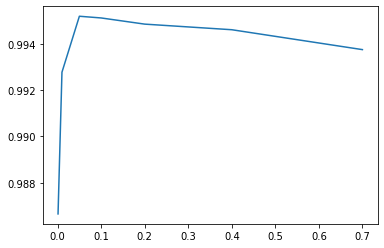

In [93]:
rang = [0.001,0.01,0.05,0.1,0.2,0.4,0.7]
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(df=data_for_xgb,features=features_for_xgb,eta=x,verbosity=0)
    print(x,np.mean(trainResults), np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

Niewielką poprawę uzyskujemy przy zastosowaniu parametru eta=0.05. Kolejnym parametrem, który warto przetestować jest głębokość pojedynczego drzewa

4 0.9950463131621448 0.9940007601458645
5 0.9967287970125778 0.9948078595418369
6 0.9980684184064799 0.9951425884482774
7 0.9985880783033517 0.9951913257460963
8 0.9992820099065053 0.9952590553161695
9 0.9995890130829153 0.9952620170198113
10 0.999763702402541 0.9952410385695618
11 0.9999256341281579 0.9952014179937028


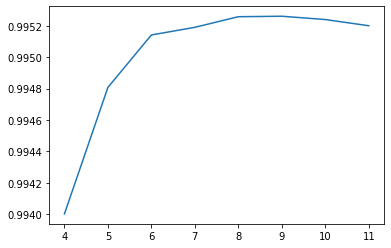

In [94]:
rang = range(4,12)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(df=data_for_xgb,features=features_for_xgb,eta=0.05,max_depth=x,verbosity=0)
    print(x, np.mean(trainResults),np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

Według wyników można uznać, że 9 to najlepsza głębokość drzewa i przejść do szukania najlepszej wartości udziału obserwacji oraz zmiennych w danym drzewie

0.2 0.9984842390272235 0.9945153676113581
0.3 0.9989767823264846 0.9948267588576627
0.4 0.999432472549505 0.9950078446668167
0.5 0.9994276493784128 0.9951018199243199
0.6 0.9995002221065785 0.9951756693180831
0.7 0.9995890130829153 0.9952620170198113
0.8 0.9995600741373953 0.9953145835137669
0.9 0.9995318346999389 0.9953273398722384


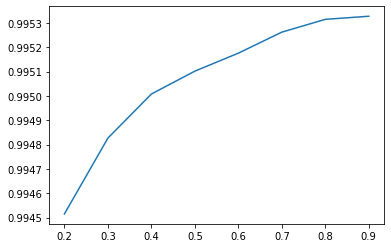

In [106]:
rang = range(2,10)
rang=list(map(lambda x:x/10,rang))
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(df=data_for_xgb,features=features_for_xgb,eta=0.05,max_depth=9,subsample=x,verbosity=0)
    print(x, np.mean(trainResults), np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(rang, results)
plt.show()

Najlepszy wynik ustalił się przy wartości 0.9, dlatego zostawiamy taką wartość. Teraz przeszukajmy najlepszą wartość udziału zmiennych w drzewie

0.2 0.998407582125405 0.9930538184285664
0.3 0.9995504128327983 0.9945630324926981
0.4 0.9997025229722981 0.9949936025478632
0.5 0.9997444809748901 0.9951742872470497
0.6 0.9996810631252732 0.9952555685144704
0.7 0.9995318346999389 0.9953273398722384
0.8 0.9995724693394491 0.9953586614466421
0.9 0.9995370199837892 0.995348857941401


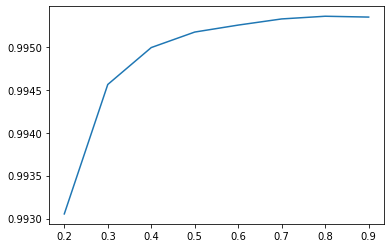

In [107]:
rang = range(2,10)
rang=list(map(lambda x:x/10,rang))
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(df=data_for_xgb,features=features_for_xgb,eta=0.05,max_depth=9,subsample=0.9,colsample_bytree = x,verbosity=0)
    print(x, np.mean(trainResults), np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(rang, results)
plt.show()

Najlepsze wyniki otrzymujemy dla wartości 0.8. W modelu Xgboost jesteśmy również w stanie poradzić sobie z nadmiernym przetrenowaniem. Dlatego sprawdźmy czy dobranie optymalnych parametrów regularyzujących w xgboost pomoże ograniczyć nadmierne dopasowanie jednocześnie poprawiając wynik na zbiorze testowym. Najcześciej stosowaną regularyzacją jest L2, dlatego to i ją wykorzystamy w tym problemie.

0 0.9997257040240995 0.9952841768435086
1 0.9995724693394491 0.9953586614466421
4 0.9993802483177676 0.9953603817418273
9 0.9992245957533159 0.9953795391777007
16 0.9989044218248001 0.9953618771619895
25 0.998728571009357 0.9953457725178371
36 0.9983691322419073 0.9952766070460477
49 0.9980146758812468 0.9952425238474598


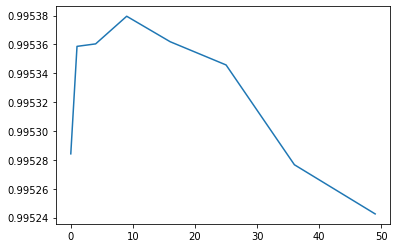

In [108]:
rang = range(0,8)
rang=list(map(lambda x:x**2,rang))
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(df=data_for_xgb,features=features_for_xgb,eta=0.05,max_depth=9,subsample=0.9,colsample_bytree = 0.8,lambdaX=x,verbosity=0)
    print(x, np.mean(trainResults),np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

Najlepszy wynik otrzymano dla lambda=9. Innym parametrem, który pomaga walczyć z regularyzacją jest gamma, który wpływa na decyzję o tym czy dokonać kolejnego splitu w zależności jak bardzo będzie to pomocne, czyli jak obniży się funkcja straty. Przy wprowadzaniu kolejnej regularyzacji warto obniżyć parametr lambda, ustawmy go na wartości 5

0.01 0.9992704788982044 0.9953611319919062
0.1 0.9994718844295901 0.9953702427943549
0.5 0.9992332322897498 0.9953743613246869
1 0.9991458505338248 0.9953795285547992
2 0.998632827788535 0.9954046842095903
4 0.9976396597780035 0.9954111014057231
6 0.996839573139859 0.9953590113040967
8 0.9963448486168931 0.9952613566946884
10 0.9960469889698533 0.9951594923580596


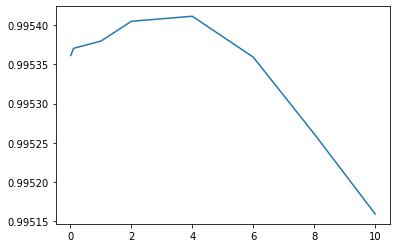

In [109]:
rang = [0.01, 0.1, 0.5, 1, 2, 4, 6, 8, 10]
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(df=data_for_xgb,features=features_for_xgb,eta=0.05,max_depth=9,subsample=0.9,colsample_bytree = 0.8,lambdaX=5,gamma=x,verbosity=0)
    print(x, np.mean(trainResults),np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

Dla gammy=4 uzyskaliśmy najlepszy dotychczas wynik (0.995411). Prawdopodobnie możliwa jest jeszcze większa poprawa wyniku predykcji, jednakże uzyskany rezultat jest bardzo dobry, dlatego zapiszmy ten wynik i przejdźmy do podsumowania

In [110]:
trainResults, testResults, predictions, indices, hists = CVTestXGB(
        df=data_for_xgb,features=features_for_xgb,eta=0.05,max_depth=9,subsample=0.9,colsample_bytree = 0.8,lambdaX=5,gamma=4,verbosity=0)
print(np.mean(testResults))

modelXGB = {
    "name":"XGB",
    "description":"Model XGB, ze zmiennymi kategorycznymi z LE",
    "specification":'eta=0.05,max_depth=9, subsample = 0.9, colsample_bytree = 0.8, lambdaX=5, gamma=4',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.9954111014057231


## Podsumowanie

Podsumowanie zawiera porównanie wyników wszystkich 4 najlepszych modeli za pomocą wykresu krzywej ROC.

In [120]:
def plotROCs(results):
    ''' Funkcja, do rysowania szeregu wyników krzywych ROC dla poszczególnych eksperymentów
    results - lista wyników jako 3 elementowe tuple (true, pred, label)
    '''
    
    # Ustalanie wielkości rysunku
    fig, ax = plt.subplots(figsize=(10,9))
        
    for true, pred, label in results:
        # Obliczenie punktów potrzebnych do narysowani akrzywej ROC
        # funkcja roc_curve zwarca trzy serie danych, fpr, tpr oraz poziomy progów odcięcia
        fpr, tpr, thresholds = roc_curve(true, pred)
        # Obliczamy pole powierzchni pod krzywą
        rocScore = roc_auc_score(true, pred)
        rocScore = round(rocScore, 4)
        

        # Grubość krzywej
        lw = 2

        # Rysujemy krzywą ROC
        ax.plot(fpr, tpr, lw=lw, label=f'{label}: {rocScore}')
    # Rysujemy krzywą 45 stopni jako punkt odniesienia
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    # Dodajemy lekkie marginesy do zakresu aby krzywa nie pokrywała się z osiami
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()


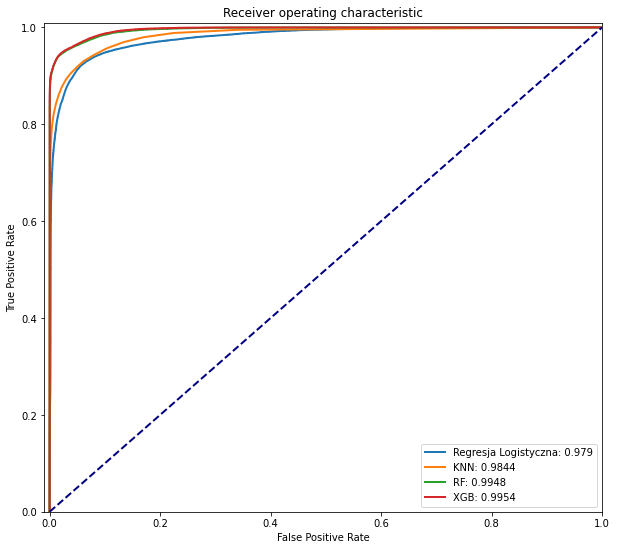

In [121]:
res2plot = []
true = (df[target]=='satisfied').astype(int).sort_index()
for result in [modelLR, modelkNN, modelRF, modelXGB]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Wywołujemy funkcję do rysowania
plotROCs(res2plot)

Ostatecznie najlepsze wyniki dają modele oparte o drzewa decyzyjne. Zarówno RandomForest jak i XGBoost z estymatorem drzew decyzyjnych daje wynik na poziomie 0.995 i różnią się one dopiero 4 miejscem po przecinku. Generalnie próba, na której bazował ten problem klasyfikacyjny była na tyle duża, że otrzymywane wyniki są do siebie bardzo zbliżone. Można uznać, że przewagą XGBoost nad RandomForest jest fakt, że najlepszy model xgboost nie przetrenowuje się tak jak najlepszy model z RandomForest.